In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import torch_geometric.explain as TE
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from create_graph import create_graph
from cell_model import load_model_from_path
from render_3d_deconv import add_cell_heatmap_layer
from load_datasets import load_patient
from adapt_for_cell_graph_models import adapt_for_cell_graph_models
import gene_sets
import torch

In [17]:
# dataset is wrapped using `adapt_for_cell_graph_models.py`
def predict_and_explain_with_nodes(model, dataset, spot_index, gene_index):
    (cell_images, cell_locations, cell_detection_indexes), label = dataset[spot_index]

    return predict_and_explain_with_nodes_helper(model, cell_images, cell_locations, cell_detection_indexes, gene_index)

def predict_and_explain_with_nodes_helper(model, cell_images, cell_locations, cell_detection_indexes, gene_index):
    explainer = TE.Explainer(
        model=model,
        algorithm=TE.GNNExplainer(epochs=200),
        explanation_type='model',
        node_mask_type='object',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='graph',
            return_type='raw',
        ),
        threshold_config=dict(threshold_type='topk', value=10)
    )

    with torch.no_grad():
        cell_embeddings = model.image_embedder(cell_images)
    
    data = create_graph(cell_embeddings, cell_locations)

    explanation = explainer(
        data.x,
        data.edge_index,
        # This is a keyword argument passed to the model.
        input_type='nodes_and_edges',
    )
    
    return (data.edge_index, explanation.edge_mask, explanation.node_mask)

In [4]:
genes = gene_sets.GENE_SETS['cytassist-autostainer-top1k-by-rank-mean']
autostainer_dataset = adapt_for_cell_graph_models(load_patient('autostainer', genes))
model_path = './training_results_v2/v0_repr/cellmodel_prior-repr_heldout-autostainer_model.pt'
model = load_model_from_path(model_path, len(genes)).to('cuda')

/dartfs-hpc/rc/home/x/f006jnx/anaconda3/envs/pyg/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


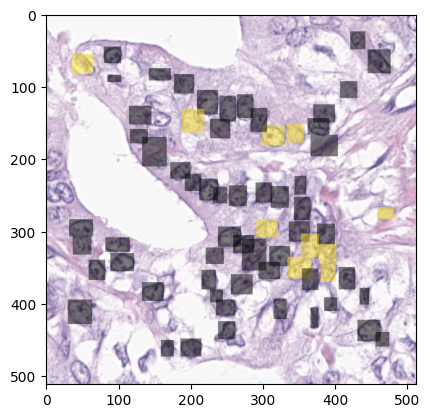

In [38]:
autostainer_patchdataset = autostainer_dataset.inner
autostainer_patchdataset.patch_transform = None
index = 2260
image, label, cell_detections = autostainer_patchdataset[index]
((cell_images, cell_locations, cell_detection_indexes), (label)) = autostainer_dataset[index]
cmap = plt.get_cmap('viridis')
boxes = [cell_detections['boxes'][i] for i in cell_detection_indexes]
edge_index, edge_mask, node_mask = predict_and_explain_with_nodes(model, autostainer_dataset, index, genes.index("EPCAM"))
image_cpu = image.cpu()
node_mask2 = node_mask[:, 0].cpu()
node_mask3 = (node_mask2 - node_mask2.min())/(node_mask2.max()-node_mask2.max())
add_cell_heatmap_layer(image_cpu, node_mask3, boxes, 0, 0, cmap)
pi = TF.to_pil_image(image_cpu)
plt.imshow(pi)

In [22]:
nm.shape

torch.Size([62, 1])